In [1]:
# initializations
%matplotlib notebook
import matplotlib
# make figures smaller
matplotlib.rc('figure', figsize=(5, 3.75))

import numpy.linalg
from scipy.optimize import leastsq
from diffpy.srfit.fitbase import FitRecipe, FitResults
from cdse_functions import differenceplot

## PDF refinement of CdSe nanocluster

We have x-ray PDF data measured from a solution of nanosized CdSe clusters.
Here we show how to model them using a shape-corrected crystalline PDF and
also with a finite-cluster model that contains all atom positions in the cluster.

**Contents**

> [Bulk PDF](#bulk-pdf)<br>
> [Spherical shape correction](#spherical-shape-correction)<br>
> [Spheroid shape correction](#pyobjcryst)<br>
> [Finite cluster model](#FIXME)

## Bulk PDF

We will set up the shape-corrected PDF fits by tweaking a simple crystal PDF model.
It is therefore convenient to define a function which creates crystal refinement from scratch. 

In [2]:
# GLOBAL CONSTANTS
c_crystalfile = 'CdSe_zinc-blende.cif'
c_clusterfile = 'CdSe_T5.xyz'
c_pdfdatafile = 'CdSe.gr'
c_fitrange = (1, 20)
c_qdamp = 0.06
c_qmin = 0.9    # Qmin cutoff in X-ray data.

In [3]:
def best_scale(ysim, yobs):
    "Return the best least-squares scaling of ysim that approximates yobs"
    sc = numpy.dot(yobs, ysim) / numpy.dot(ysim, ysim)
    return sc


def new_crystal_fit():
    from diffpy.srfit.pdf import PDFContribution
    from pyobjcryst import loadCrystal
    gtot = PDFContribution('gtot')
    gtot.qdamp = c_qdamp
    gtot.loadData(c_pdfdatafile)
    crst = loadCrystal(c_crystalfile)
    gtot.addStructure('cdse', crst)
    gtot.profile.setCalculationRange(*c_fitrange)
    fit = FitRecipe()
    fit.clearFitHooks()
    fit.addContribution(gtot)
    sc0 = best_scale(gtot.evaluate(), gtot.profile.y)
    fit.addVar(gtot.scale, value=sc0)
    fit.addVar(gtot.cdse.delta2, value=1)
    fit.addVar(gtot.cdse.phase.sgpars.latpars.a)
    fit.addVar(gtot.cdse.phase.Cd1.Biso, name='BisoCd')
    fit.addVar(gtot.cdse.phase.Se1.Biso, name='BisoSe')
    return fit

Let us start with bulk crystal PDF model.

<IPython.core.display.Javascript object>


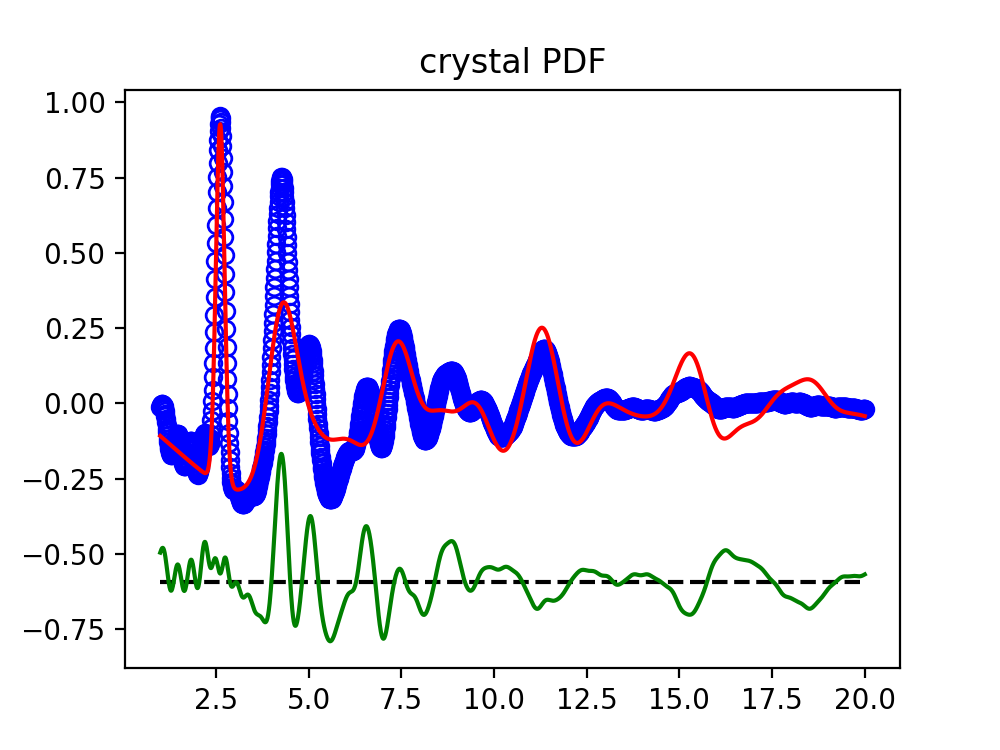

In [4]:
fcrystal = new_crystal_fit()
leastsq(fcrystal.residual, fcrystal.values)
differenceplot(fcrystal, fig=1, title='crystal PDF');

In [5]:
rescrystal = FitResults(fcrystal)
print("Rw =", rescrystal.rw)

Rw = 0.4962582098375881


## Spherical shape correction

We will start with bulk PDF model and then
add spherical shape correction factor to the PDF formula.

old equation: (scale * cdse())
new equation: ((scale * cdse()) * fsphere(r, psize))


<IPython.core.display.Javascript object>


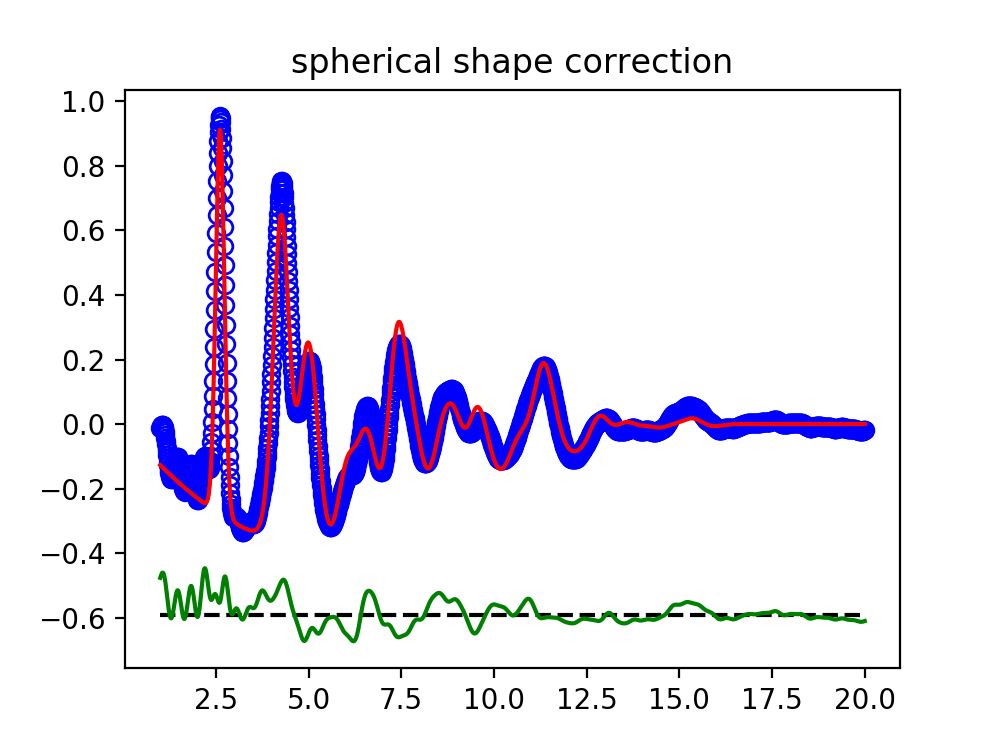

In [6]:
fsphere = new_crystal_fit()

# srfit has several shape functions of its own and
# also allows to use shape factors from SasView when installed
from diffpy.srfit.pdf.characteristicfunctions import sphericalCF
# The sphericalCF needs to be registered so it is available in symbolic formula
fsphere.gtot.registerFunction(sphericalCF, name='fsphere')
print("old equation:", fsphere.gtot.getEquation())
fsphere.gtot.setEquation('scale * cdse * fsphere')
print("new equation:", fsphere.gtot.getEquation())
# the sphericalCF argument `psize` is now available as a parameter in the fit
# here we mark it for refinement
fsphere.addVar(fsphere.gtot.psize, value=20)

# fit it and plot it
leastsq(fsphere.residual, fsphere.values)
differenceplot(fsphere, fig=2, title='spherical shape correction');

In [7]:
ressphere = FitResults(fsphere)
print("Rw =", ressphere.rw)

Rw = 0.22872299157096956


## Spheroid shape correction

This is sphere stretched along 1 axis.  The shape function has
2 arguments `psize` for the initial diabeter and `axrat` giving
the ratio of the third axis.

<IPython.core.display.Javascript object>


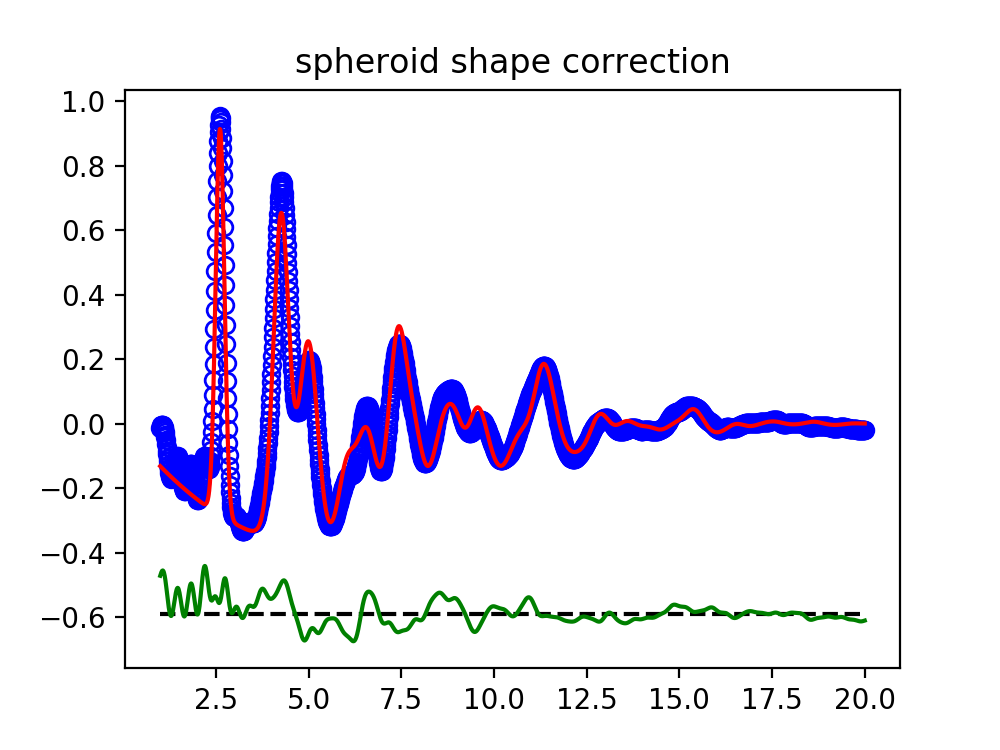

In [8]:
# let us call this fit `fegg` for a better naming clarity
fegg = new_crystal_fit()
from diffpy.srfit.pdf.characteristicfunctions import spheroidalCF2
fegg.gtot.registerFunction(spheroidalCF2, name='eggshape')
fegg.gtot.setEquation('scale * cdse * eggshape')
fegg.addVar(fegg.gtot.psize, value=20)
fegg.addVar(fegg.gtot.axrat, value=1)
leastsq(fegg.residual, fegg.values)
differenceplot(fegg, fig=3, title='spheroid shape correction');

In [9]:
resegg = FitResults(fegg)
print(resegg)

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       2.92982548
Contributions  2.92982548
Restraints     0.00000000
Chi2           2.92982548
Reduced Chi2   0.00154690
Rw             0.22516681

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
BisoCd  2.18764699e+00 +/- 1.28327461e+00
BisoSe  3.95087504e+00 +/- 3.61187556e+00
a       6.03979764e+00 +/- 3.84231556e-02
axrat   4.33340720e-01 +/- 7.87845067e-01
delta2  5.61932107e+00 +/- 8.88937748e-01
psize   2.38864455e+01 +/- 1.87859431e+01
scale   3.19744365e-01 +/- 1.00079991e-01

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(psize, axrat)     -0.9508
corr(delta2, BisoSe)   0.6776
corr(scale, axrat)     -0.6535
corr(scale, psize)     0

The *Rw* is almost the same as for spherical correction.
Nearly full correlation between psize and axrat points to a poor model quality

## Finite cluster model

Here we simulate PDF with a finite CdSe cluster.

In [10]:
def new_cdsecluster_fit():
    from diffpy.srfit.pdf import PDFContribution
    from diffpy.structure import loadStructure
    gtot = PDFContribution('gtot')
    gtot.qdamp = c_qdamp
    gtot.setQmin(c_qmin)
    gtot.loadData(c_pdfdatafile)
    cluster = loadStructure(c_clusterfile)
    gtot.addStructure('cdse', cluster, periodic=False)
    gtot.profile.setCalculationRange(*c_fitrange)
    fit = FitRecipe()
    fit.clearFitHooks()
    fit.addContribution(gtot)
    sc0 = best_scale(gtot.evaluate(), gtot.profile.y)
    fit.addVar(gtot.scale, sc0)
    fit.addVar(gtot.cdse.delta2, value=1)
    fit.newVar('expansion', value=0)
    fit.newVar('BisoCd', 0.5)
    fit.newVar('BisoSe', 0.5)
    ph = gtot.cdse.phase
    fit.constrain(ph.lattice.a, '(1 + expansion)')
    fit.constrain(ph.lattice.b, '(1 + expansion)')
    fit.constrain(ph.lattice.c, '(1 + expansion)')
    for pa in gtot.cdse.phase.atoms:
        if pa.atom.element == "Cd":
            fit.constrain(pa.Biso, 'BisoCd')
        if pa.atom.element == "Se":
            fit.constrain(pa.Biso, 'BisoSe')
    return fit

#new_cdsecluster_fit().show()

<IPython.core.display.Javascript object>


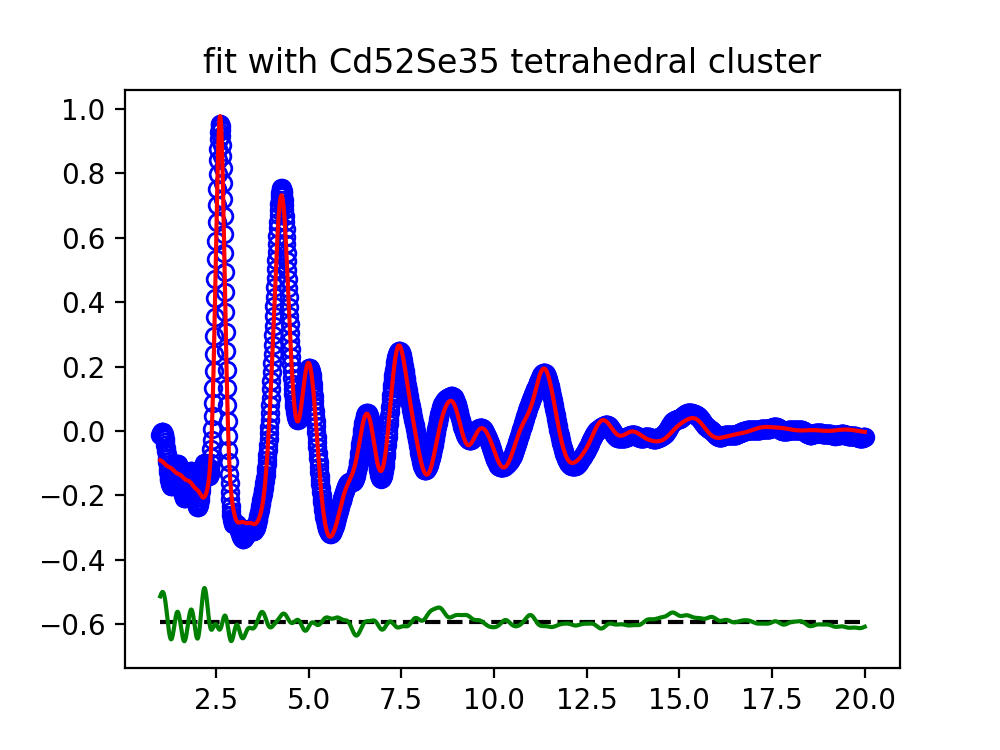

In [11]:
fcluster = new_cdsecluster_fit()
leastsq(fcluster.residual, fcluster.values)
differenceplot(fcluster, title="fit with Cd52Se35 tetrahedral cluster");

In [12]:
rescluster = FitResults(fcluster)
print(rescluster)

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       0.78342142
Contributions  0.78342142
Restraints     0.00000000
Chi2           0.78342142
Reduced Chi2   0.00041320
Rw             0.11643437

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
BisoCd     3.38740359e+00 +/- 2.68032756e+00
BisoSe     1.45318552e+00 +/- 2.92895787e+00
delta2     5.30856085e+00 +/- 9.10903633e-01
expansion  -5.74787369e-03 +/- 6.25050822e-03
scale      3.50970593e-01 +/- 6.62906913e-02

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(BisoCd, BisoSe)   -0.8088
corr(scale, BisoCd)    0.4900
corr(delta2, BisoSe)   0.3801



The finite cluster model shows excellent fit to the experiment at Rw = 0.12.

## Exercise

Task: Perform cluster fit below assuming the full Q-range, i.e., with Qmin = 0.

Hint: Qmin can be changed in existing fit using `somefit.gtot.setQmin()` function.